In [ ]:
!pip install setuptools==64.0.2
!apt-get install swig
!pip install wrds
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.1
    Uninstalling setuptools-67.6.1:
      Successfully uninstalled setuptools-67.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
cvxpy 1.3.1 requires setuptools>65.5.1, but you have setuptools 64.0.2 which is incompatible.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installe

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

##Creating Folders

In [ ]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [ ]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [ ]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2022-01-01'
TEST_START_DATE = '2022-01-01'
TEST_END_DATE = '2023-04-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2009-04-01,3.717500,3.892857,3.710357,3.303860,589372000,AAPL,2
1,2009-04-01,48.779999,48.930000,47.099998,35.911701,10850100,AMGN,2
2,2009-04-01,13.340000,14.640000,13.080000,11.688807,27701800,AXP,2
3,2009-04-01,34.520000,35.599998,34.209999,26.850748,9288800,BA,2
4,2009-04-01,27.500000,29.520000,27.440001,19.726316,15308300,CAT,2


In [ ]:
df.tail()

,date,open,high,low,close,volume,tic,day
103237,2023-03-31,471.519989,476.000000,470.100006,472.589996,3971300,UNH,4
103238,2023-03-31,223.600006,225.839996,223.289993,225.460007,9507200,V,4
103239,2023-03-31,38.790001,39.049999,38.549999,38.889999,22796000,VZ,4
103240,2023-03-31,34.820000,34.840000,34.259998,34.580002,6705800,WBA,4
103241,2023-03-31,146.580002,148.440002,146.470001,147.449997,6954400,WMT,4


In [ ]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2009-04-01,3.717500,3.892857,3.710357,3.303860,589372000,AAPL,2
1,2009-04-01,48.779999,48.930000,47.099998,35.911701,10850100,AMGN,2
2,2009-04-01,13.340000,14.640000,13.080000,11.688807,27701800,AXP,2
3,2009-04-01,34.520000,35.599998,34.209999,26.850748,9288800,BA,2
4,2009-04-01,27.500000,29.520000,27.440001,19.726316,15308300,CAT,2


In [ ]:
len(df.tic.unique()) #30 tickers

30

In [ ]:
df.tic.value_counts()

AAPL    3525
AMGN    3525
WMT     3525
WBA     3525
VZ      3525
V       3525
UNH     3525
TRV     3525
PG      3525
NKE     3525
MSFT    3525
MRK     3525
MMM     3525
MCD     3525
KO      3525
JPM     3525
JNJ     3525
INTC    3525
IBM     3525
HON     3525
HD      3525
GS      3525
DIS     3525
CVX     3525
CSCO    3525
CRM     3525
CAT     3525
BA      3525
AXP     3525
DOW     1017
Name: tic, dtype: int64

## Preprocess Data

In [ ]:
 INDICATORS = ['macd',
               'rsi_30',
               'cci_30',
               'dx_30']

In [ ]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [ ]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
43379,2015-03-11,112.900002,113.589996,112.639999,99.791100,2593700,UNH,2,1.316010,57.804397,52.066544,13.633774,25.790404
24004,2012-07-12,22.980000,23.059999,22.552500,20.324335,14964800,NKE,3,-0.810543,38.248480,-93.120902,43.288933,119.649679
34859,2014-01-09,116.540001,118.959999,116.220001,92.663712,3400000,AMGN,3,0.623993,57.881039,280.058981,28.255967,21.164043
53782,2016-08-11,43.720001,43.869999,43.619999,35.239964,11303300,KO,3,-0.340990,44.458430,-69.116309,20.875683,10.518166
61203,2017-08-17,35.599998,35.680000,35.169998,30.072041,19525000,INTC,3,0.290403,49.720039,11.976228,11.146887,28.222956


## Design Environment

Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a Markov Decision Process (MDP) problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [ ]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [ ]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

## Implement DRL Algorithms

* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* I am training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [ ]:
rebalance_window = 63 #63 # rebalance_window is the number of days to retrain the model
validation_window = 63 #63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)



In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2, #2048
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 1, #10_000
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 1, #10_000 each
                 'ppo' : 1, 
                 'ddpg' : 1
                 }

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  200.7966458616463
======Model training from:  2009-04-01 to  2022-01-03
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_1
======A2C Validation from:  2022-01-03 to  2022-04-04
A2C Sharpe Ratio:  -0.23709538625635063
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ppo_126_1
-----------------------------------
| time/              |            |
|    fps             | 29         |
|    iterations      | 1          |
|    time_elapsed    | 0          |
|    total_timesteps | 2          |
| train/             |            |
|    reward          | 0.05335519 |
-----------------------------------
======PPO Validation from:  2022-01-03 to  2022-04-04
PPO Sharpe Ratio:  -0.23382111767768368
======DDPG Training========
{'buffer_s

In [ ]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2022-01-03,2022-04-04,PPO,-0.237095,-0.233821,-0.265129
1,189,2022-04-04,2022-07-06,DDPG,-0.250181,-0.301705,-0.208615
2,252,2022-07-06,2022-10-04,DDPG,-0.202259,-0.176888,-0.064297


## Backtesting the strategy
To measure performance of trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [ ]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.004108532801158765


In [ ]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2022-04-04,NaN,2022-04-04
1,9.993154e+05,2022-04-05,-0.000685,2022-04-05
2,9.966693e+05,2022-04-06,-0.002648,2022-04-06
3,9.986248e+05,2022-04-07,0.001962,2022-04-07
4,1.001302e+06,2022-04-08,0.002680,2022-04-08


<Axes: >

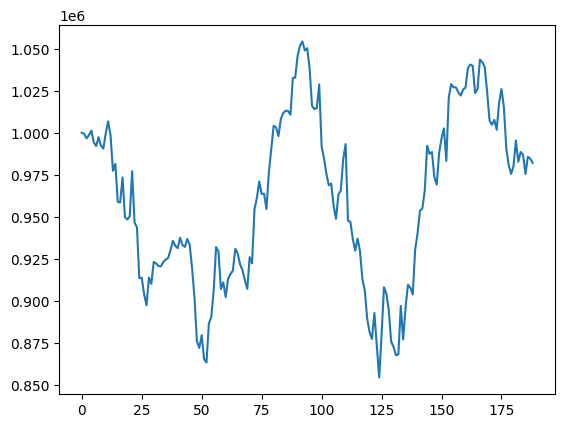

In [ ]:
%matplotlib inline
df_account_value.account_value.plot()

pass in df_account_value, this information is stored in env class

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.023804
Cumulative returns    -0.017907
Annual volatility      0.216592
Sharpe ratio          -0.004109
Calmar ratio          -0.125560
Stability              0.079908
Max drawdown          -0.189581
Omega ratio            0.999293
Sortino ratio         -0.005924
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.152058
Daily value at risk   -0.027291
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (188, 8)
Annual return         -0.067521
Cumulative returns    -0.050817
Annual volatility      0.207899
Sharpe ratio          -0.234486
Calmar ratio          -0.368916
Stability              0.002484
Max drawdown          -0.183024
Omega ratio            0.961703
Sortino ratio         -0.327108
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.927461
Daily value at risk   -0.026386
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (188, 8)


Start date,2022-04-04
End date,2023-01-03
Total months,9
,Backtest
Annual return,-2.38%
Cumulative returns,-1.791%
Annual volatility,21.659%
Sharpe ratio,-0.00
Calmar ratio,-0.13
Stability,0.08
Max drawdown,-18.958%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,18.96,2022-08-16,2022-09-30,NaT,NaN
1,14.25,2022-04-20,2022-06-17,2022-08-03,76
2,1.07,2022-04-08,2022-04-18,2022-04-20,9
3,0.33,2022-04-04,2022-04-06,2022-04-08,5
4,0.24,2022-08-05,2022-08-09,2022-08-10,4


Stress Events,mean,min,max
New Normal,-0.00%,-4.58%,3.81%


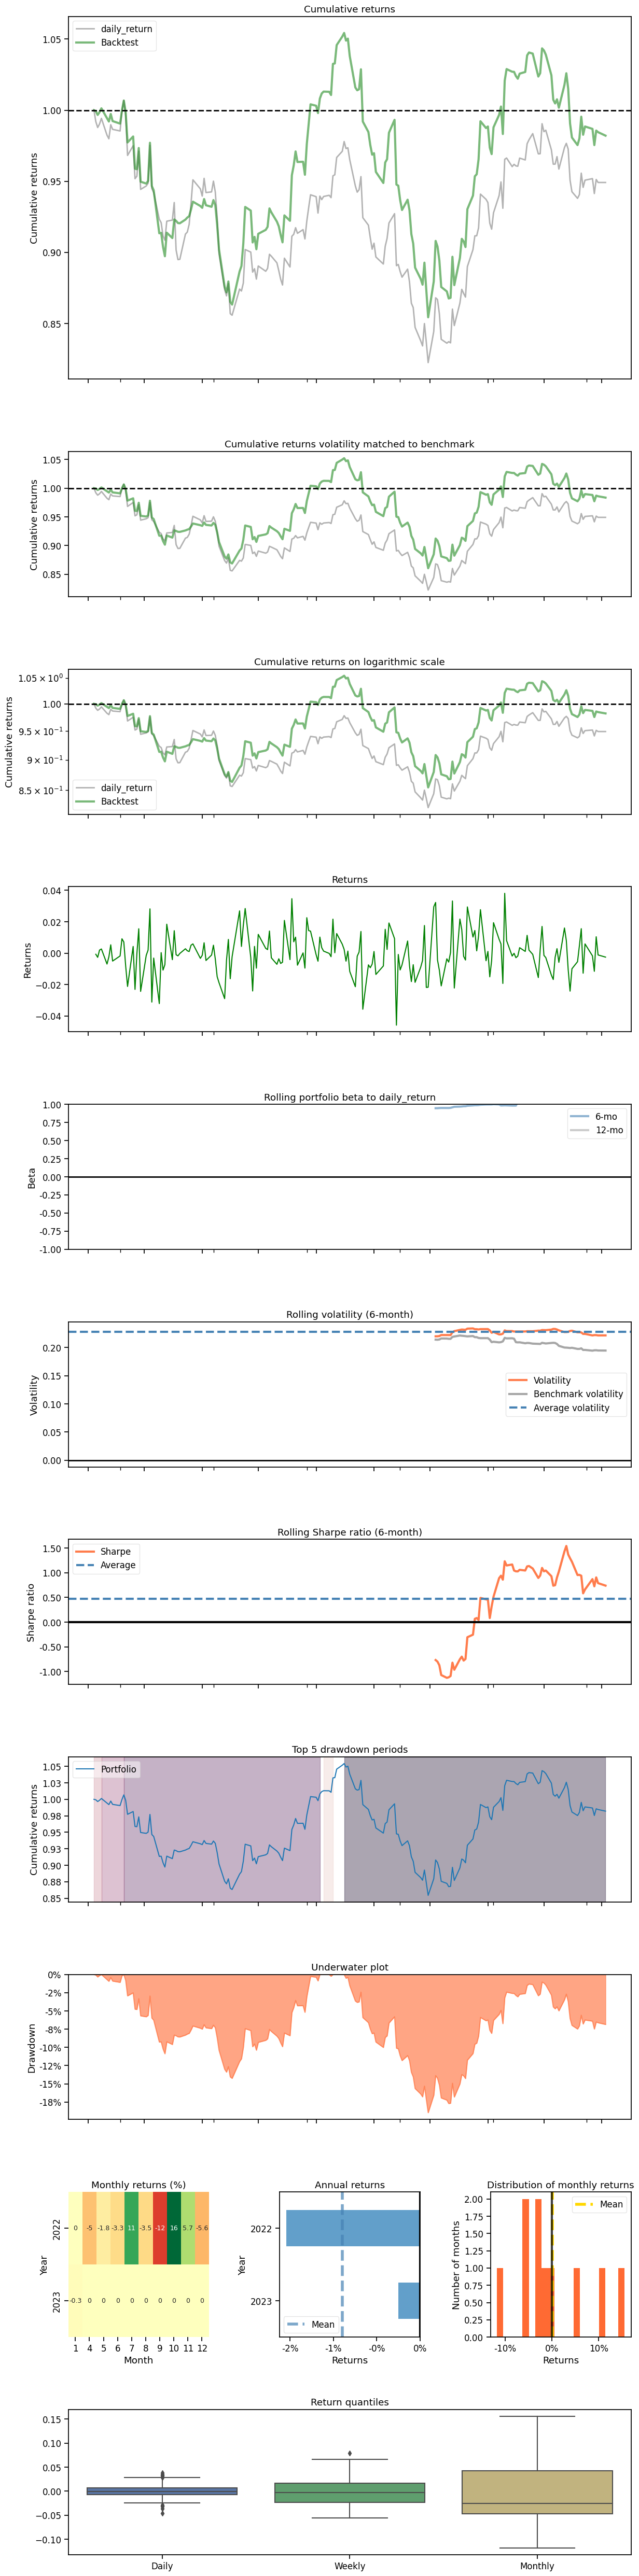

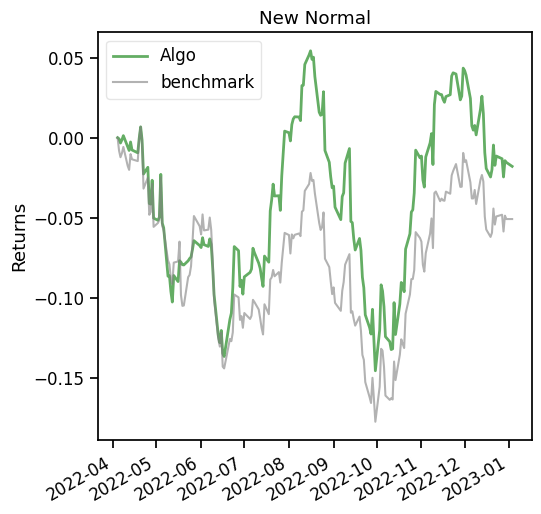

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = '^DJI', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [ ]:
!pip install alpaca-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/96.3 KB 8.6 MB/s eta 0:00:00


In [ ]:
!pip install alpaca

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for alpaca: filename=alpaca-1.0.0-py3-none-any.whl size=14089 sha256=fe5b142cfd4fd5869eb83262974fd272b8b91bb43c28b6f18f50891c887091e2
  Stored in directory: /root/.cache/pip/wheels/41/a1/e3/f5a94eabd03128db3256f1a3248011ef9ea76f24232acca046
Successfully built alpaca


In [ ]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import datetime as datetime
from alpaca.data.live import StockDataStream
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.trading.requests import LimitOrderRequest

# # paper=True enables paper trading
trading_client = TradingClient('PK61I3NSG41CADF2A3VK', 'AmhfV8xJKIDBO9wiao4O4he7DRichuYKLg744FFb', paper=True)


##Market Order 
# preparing orders
market_order_data = MarketOrderRequest(
                    symbol="AAPL",
                    qty=10,
                    side=OrderSide.BUY,
                    time_in_force=TimeInForce.DAY
                    )

# Market order
market_order = trading_client.submit_order(
                order_data=market_order_data
               )
